In [8]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# GPU memory growth (optional, prevents TF errors when GPU present)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import backend as K

# Print versions for debugging
print("TF version:", tf.__version__)


TF version: 2.19.0


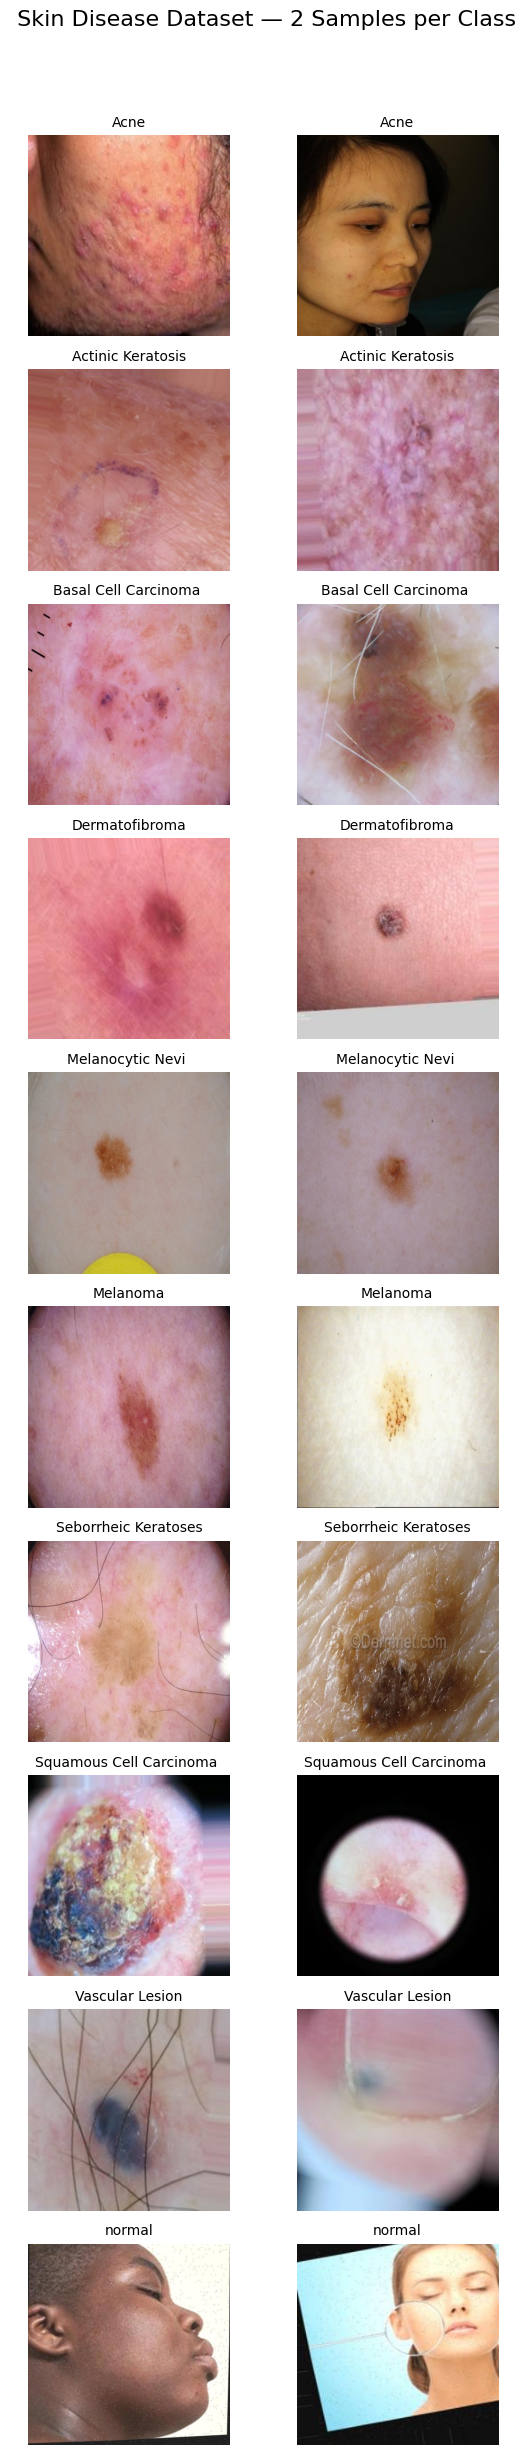

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your dataset
base_dir = "/home/jay/Face_Analysis/datasets/skin_diseases_balanced/train"  # 👈 pick train/val/test explicitly

# Valid image extensions
valid_exts = (".jpg", ".jpeg", ".png")

# Automatically get sorted class names/folder names
class_labels = sorted(os.listdir(base_dir))
images_per_class = 2
num_classes = len(class_labels)

# grid plot
plt.figure(figsize=(images_per_class * 3, num_classes * 2.5))

for class_idx, class_name in enumerate(class_labels):
    class_dir = os.path.join(base_dir, class_name)

    # Filter only image files
    image_files = [
        f for f in os.listdir(class_dir)
        if f.lower().endswith(valid_exts)
    ][:images_per_class]

    for img_idx, img_file in enumerate(image_files):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path)

        plot_index = class_idx * images_per_class + img_idx + 1
        plt.subplot(num_classes, images_per_class, plot_index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name, fontsize=10)

plt.suptitle(" Skin Disease Dataset — 2 Samples per Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()



In [11]:
from collections import Counter
class_labels = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir,d))])
class_counts = {cls: len([f for f in os.listdir(os.path.join(base_dir, cls)) if f.lower().endswith(('jpg','png','jpeg'))]) for cls in class_labels}
print("Class counts (sorted):")
for k,v in class_counts.items():
    print(f"{k}: {v}")


Class counts (sorted):
Acne: 2533
Actinic Keratosis: 6140
Basal Cell Carcinoma : 2695
Dermatofibroma: 7494
Melanocytic Nevi : 6226
Melanoma: 4467
Seborrheic Keratoses: 2600
Squamous Cell Carcinoma : 6639
Vascular Lesion: 7407
normal: 5555


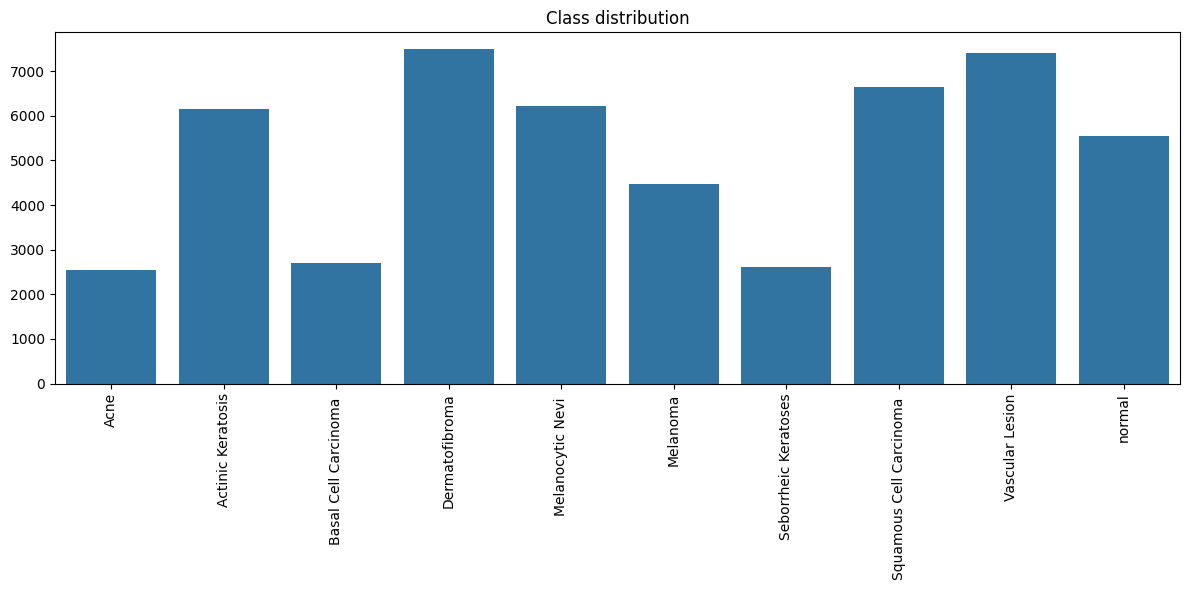

Class weights: {0: np.float64(2.043268851164627), 1: np.float64(0.8429315960912052), 2: np.float64(1.9204452690166975), 3: np.float64(0.6906325060048039), 4: np.float64(0.8312881464824927), 5: np.float64(1.1586299529885828), 6: np.float64(1.9906153846153847), 7: np.float64(0.7795752372345233), 8: np.float64(0.6987444309437019), 9: np.float64(0.9317011701170117)}


In [12]:
plt.figure(figsize=(12,6))
keys = list(class_counts.keys())
vals = [class_counts[k] for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=90)
plt.title("Class distribution")
plt.tight_layout()
plt.show()

# compute class weights (use later in model.fit)
from sklearn.utils.class_weight import compute_class_weight
class_indices = {cls:i for i,cls in enumerate(class_labels)}
y = []
for cls, count in class_counts.items():
    y += [class_indices[cls]] * count
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.array(y))
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)



In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=(0.8,1.2),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)


In [15]:
batch_size = 32
base_dir = "/home/jay/Face_Analysis/datasets/skin_diseases_balanced"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "test")


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)


Found 51756 images belonging to 10 classes.
Found 10263 images belonging to 10 classes.


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

num_classes = len(class_labels)  # ensure this is defined

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze for initial training

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,610 (9.89 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [17]:
# Unfreeze some top layers and fine-tune
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "saved_models/mobilenet_skin.keras"  # centralized folder

os.makedirs("saved_models", exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,   # <<-- IMPORTANT: save full model, not only weights
    mode='max'
)

early = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

callback_list = [checkpoint, early, reduce_lr]


In [20]:
epochs = 30
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callback_list,
    class_weight=class_weight_dict, 
    verbose=1
)


/home/jay/my-jupyter-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 147/1617 ━━━━━━━━━━━━━━━━━━━━ 13:49 565ms/step - accuracy: 0.1554 - loss: 3.0684

KeyboardInterrupt: 

In [ ]:
# After training finishes and callback restored the best weights
model.save("saved_models/mobilenet_skin_final.keras", include_optimizer=False)
print("Saved final model at saved_models/mobilenet_skin_final.keras")


In [ ]:
# Get true labels & predictions
test_generator = val_generator  # or a separate test generator with shuffle=False
test_generator.reset()
pred_proba = model.predict(test_generator, steps=test_generator.samples // batch_size + 1, verbose=1)
pred_labels = np.argmax(pred_proba, axis=1)

# true labels from generator
true_labels = test_generator.classes[:len(pred_labels)]

# label mapping
idx_to_class = {v:k for k,v in train_generator.class_indices.items()}
pred_class_names = [idx_to_class[i] for i in pred_labels]
true_class_names = [idx_to_class[i] for i in true_labels]

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, pred_labels)
print(classification_report(true_labels, pred_labels, target_names=list(idx_to_class.values())))

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(idx_to_class.values()), yticklabels=list(idx_to_class.values()), cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


In [ ]:
# Quick verification of saved model input shape for inference
from tensorflow.keras.models import load_model
m = load_model("saved_models/mobilenet_skin_final.keras")
print("Loaded saved model input shape:", m.input_shape)
